# Notebook 03: Veri Hikâyesi ve İş Önerileri

Bu notebook’ta, önceki analiz notebook’larında elde edilen bulgular bir araya getirilerek ilçe bazlı bir veri hikâyesi oluşturulmuştur. Amaç, tahakkuk ve tahsilat verilerinden elde edilen sonuçları karşılaştırmalı olarak yorumlamak ve bu bulgular üzerinden işlevsel ve uygulanabilir öneriler sunmaktır.

---

## 1. Veri Hazırlık Aşaması

Bu bölümde, önceki notebook’larda analiz edilen pkl verileri yeniden yüklenmiş ve ilçe bazlı karşılaştırmaların yapılabilmesi için gerekli kütüphanelerin yüklenmesi gerçekleştirilmiştir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

if not os.path.exists('../outputs/figures_nb3'):
    os.makedirs('../outputs/figures_nb3')
    
colors1 = ["#3182ce", "#38a169", "#ed8936", "#805ad5", "#e53e3e"]

In [3]:
df_tahakkuk = pd.read_pickle("../processed_data/tahakkuk_clean.pkl")
df_tahsilat = pd.read_pickle("../processed_data/tahsilat_clean.pkl")
df_tahsilat_1 = pd.read_pickle("../processed_data/tahsilat_1_clean.pkl")
    
print(f"Tahakkuk Kayıt Sayısı: {len(df_tahakkuk)}")
print(f"Tahsilat Kayıt Sayısı: {len(df_tahsilat)}")
print(f"Tahsilat 1 Kayıt Sayısı: {len(df_tahsilat_1)}")

Tahakkuk Kayıt Sayısı: 1185547
Tahsilat Kayıt Sayısı: 636993
Tahsilat 1 Kayıt Sayısı: 917632


## 2. Bölgesel Karşılaştırma Analizi

Bu bölümde, ilçeler arasındaki tüketim ve tahsilat farklarının nedenleri incelenmektedir.

**Temel Soru:**  
Hamamözü ilçesi, diğer ilçelere kıyasla neden daha düşük toplam tüketim ve tahsilat hacmi göstermektedir?

**Hipotez:**  
Bu durumun, ilçedeki abone sayısının görece düşük olması ve mesken dışı (ticari/sanayi) abonelerin sınırlı olmasıyla ilişkili olabileceği düşünülmektedir.

Aşağıdaki analizler ile bu hipotez test edilecektir.

---

              Toplam_Tuketim  Ortalama_Tuketim  Musteri_Sayisi
Ilce_Adi                                                      
Gümüşhacıköy     74620566.74         97.473146           18190
Göynücek         26488836.34         89.736998            7128
Hamamözü          8848406.62         70.892741            2981


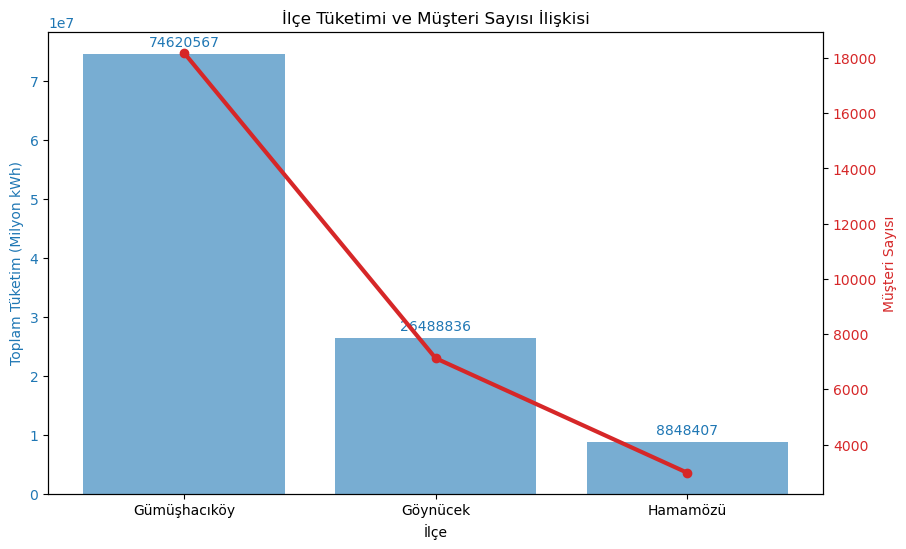

In [6]:
# İlçe Bazında Ortalama Tüketim vs Toplam Tüketim
district_stats = df_tahakkuk.groupby('Ilce_Adi').agg(Toplam_Tuketim=('kwh', 'sum'),
    Ortalama_Tuketim=('kwh', 'mean'),
    Musteri_Sayisi=('sozlesme_hesap_no', 'nunique')).sort_values('Toplam_Tuketim', ascending=False)

print(district_stats)

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('İlçe')
ax1.set_ylabel('Toplam Tüketim (Milyon kWh)', color=color)
ax1.bar(district_stats.index, district_stats['Toplam_Tuketim'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
for c in ax1.containers:
    ax1.bar_label(c, padding =3, fmt='%.0f', color=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Müşteri Sayısı', color=color)
ax2.plot(district_stats.index, district_stats['Musteri_Sayisi'], color=color, marker='o', linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)
for c in ax2.containers:
    ax2.bar_label(c, padding =-5, fmt='%.0f', color=color)

plt.title('İlçe Tüketimi ve Müşteri Sayısı İlişkisi')
plt.savefig('../outputs/figures_nb3/ilce_tuketim_vs_musteri_sayisi.png', dpi=300)
plt.show()

---

Bu grafiğe bakılınca ilçeler arasındaki toplam tüketim miktarında devasa farklar olduğu gözlemlenmiştir. Gümüşhacıköy'ün domine edici yapısının ana sebebini anlamak için ilk **hipotezim ilçeler arası hane sayısı farkıdır**. Veri setinde bu `Mesken` hesap sınıfında temsil edilmiştir. Eğer Gümüşhacıköy'deki mesken sayısı diğer ilçelerden kat kat fazlaysa, tüketim farkının temel kaynağı bu olabilir denilebilir.

---

In [7]:
tuketim_toplam = df_tahakkuk.groupby('Ilce_Adi')['kwh'].sum().reset_index()

# İlçe bazlı Toplam Tekil Müşteri Sayısı
musteri_toplam = df_tahakkuk.groupby('Ilce_Adi')['sozlesme_hesap_no'].nunique().reset_index()

# İlçe bazlı Sadece Mesken Tekil Müşteri Sayısı
mesken_toplam = (df_tahakkuk[df_tahakkuk['Hesap Sınıfı'] == 'Mesken'].groupby('Ilce_Adi')['sozlesme_hesap_no'].nunique().reset_index())

final_tablo = tuketim_toplam.merge(musteri_toplam, on='Ilce_Adi')
final_tablo = final_tablo.merge(mesken_toplam, on='Ilce_Adi')

# Sütun isimlerini netleştirelim
final_tablo.columns = ['Ilce_Adi', 'Toplam_kWh', 'Tum_Musteri_Sayisi', 'Mesken_Abone_Sayisi']

# Mesken Dışı Abone
final_tablo['Ticari_ve_Diger_Abone'] = final_tablo['Tum_Musteri_Sayisi'] - final_tablo['Mesken_Abone_Sayisi']

# Toplam kWh / Mesken Sayısı
final_tablo['Yuk_Endeksi'] = final_tablo['Toplam_kWh'] / final_tablo['Mesken_Abone_Sayisi']

final_tablo = final_tablo[['Ilce_Adi','Toplam_kWh','Tum_Musteri_Sayisi','Mesken_Abone_Sayisi','Ticari_ve_Diger_Abone','Yuk_Endeksi']].sort_values(by='Toplam_kWh', ascending=False)

display(final_tablo)

,Ilce_Adi,Toplam_kWh,Tum_Musteri_Sayisi,Mesken_Abone_Sayisi,Ticari_ve_Diger_Abone,Yuk_Endeksi
1,Gümüşhacıköy,74620566.74,18190,15592,2598,4785.823932
0,Göynücek,26488836.34,7128,6217,911,4260.710365
2,Hamamözü,8848406.62,2981,2650,331,3339.021366


---

Bu sonuçlar çerçevesinde hipotez değerlendirildiğinde; eğer ilçeler arasındaki toplam enerji tüketimindeki farklılık yalnızca nüfusa bağlı olsaydı, hane başına düşen enerji yüklerinin ilçeler arasında birbirine yakın seviyelerde gerçekleşmesi beklenirdi. Ancak yapılan analizler, birim hane başına düşen toplam enerji tüketiminin ilçeler arasında belirgin farklılıklar gösterdiğini ortaya koymaktadır.

Bu durum, Gümüşhacıköy ve Göynücek ilçelerinde Hamamözü’ne kıyasla daha yüksek enerji tüketimine sahip sanayi tesisleri, ticari işletmeler ve benzeri mesken dışı kullanım alanlarının bulunduğuna işaret etmektedir.

Bu bulgular doğrultusunda **yeni hipotez**: Hamamözü ilçesinin diğer ilçelere kıyasla daha düşük toplam tüketim seviyelerinde kalmasının temel nedeninin, mesken dışı (sanayi, ticari faaliyetler, tarımsal sulama vb.) abone sınıflarının diğer ilçelere göre daha düşük olmasıdır.

Bu hipotezi test etmek amacıyla, ilçe bazında mesken ve mesken dışı abone sınıflarının toplam içindeki oranları incelenmiştir.

---

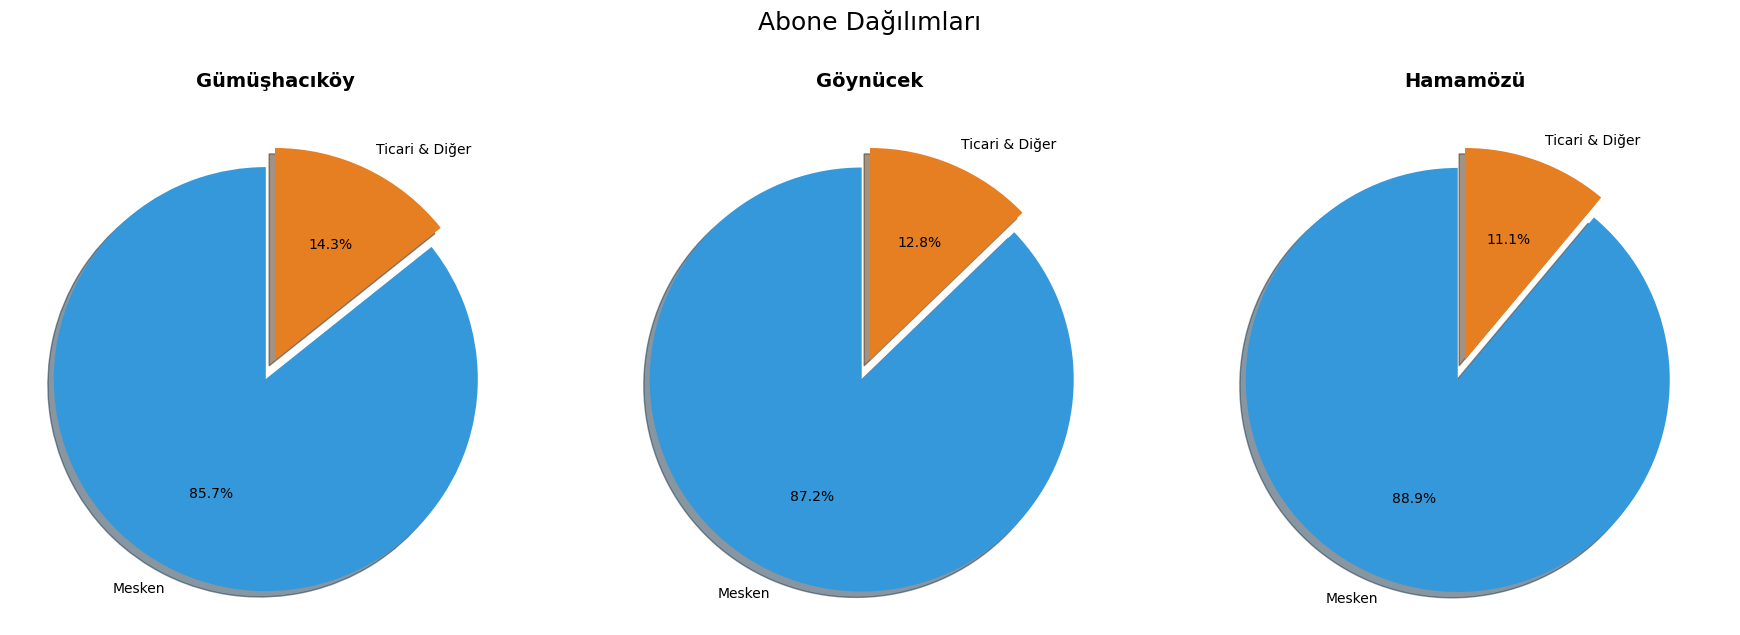

In [8]:
final_tablo['Mesken_Yüzde'] = (final_tablo['Mesken_Abone_Sayisi'] / final_tablo['Tum_Musteri_Sayisi']) * 100
final_tablo['Diger_Yüzde'] = (final_tablo['Ticari_ve_Diger_Abone'] / final_tablo['Tum_Musteri_Sayisi']) * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
colors = ['#3498db', '#e67e22']
explode = (0.1, 0)

for i, ilce in enumerate(final_tablo['Ilce_Adi']):
    bar = [final_tablo.iloc[i]['Mesken_Yüzde'], final_tablo.iloc[i]['Diger_Yüzde']]
    labels = ['Mesken', 'Ticari & Diğer']
    
    axes[i].pie(bar, labels=labels, autopct='%1.1f%%', startangle=90, 
                colors=colors, explode=explode, shadow=True)
    axes[i].set_title(f'{ilce}', fontsize=14, fontweight='bold')

plt.suptitle('Abone Dağılımları', fontsize=18, y=1.05)
plt.tight_layout()
plt.savefig('../outputs/figures_nb3/ilce_bazli_sınıf_dagilimi_pie.png', dpi=300)
plt.show()

---

Yapılan analizler sonucunda, Gümüşhacıköy ilçesinin hem toplam abone sayısı hem de %14,3 seviyesindeki ticari abone oranı ile bölge içerisinde en gelişmiş ekonomik yapıya sahip ilçe olduğu görülmektedir.

Hamamözü ilçesi ise %88,8 gibi yüksek bir mesken oranı ile konut ağırlıklı bir profil sergilemekte olup, mesken dışı tüketim sınıflarının oldukça sınırlı kaldığı anlaşılmaktadır. Göynücek ilçesi ise bu iki yapı arasında geçiş niteliğinde bir dağılım göstermektedir.

Bu dağılım, Gümüşhacıköy ilçesinin neden daha yüksek toplam enerji tüketimine ve tahsilat hacmine sahip olduğunu açıklayan temel faktörlerden biridir. Elde edilen bulgular, mesken dışı abonelerin toplam tüketim üzerindeki belirleyici etkisini açıkça ortaya koymaktadır.

Sonuç olarak, geliştirilen hipotez yapılan analizler ile test edilmiş ve desteklenmiştir.

---

### İlçe Bazlı Tüketim Farklarının Hesap Sınıfları Üzerinden İncelenmesi

Bu bölümde, ilçeler arasındaki toplam elektrik tüketimindeki farklılıklar ve bu farkların hangi abone (hesap) sınıflarından kaynaklandığı analiz edilmektedir. Bu amaçla, veri seti içerisinde toplam tüketim açısından en yüksek paya sahip ilk 15 hesap sınıfı belirlenmiştir.

Bu yaklaşım sayesinde, ilçeler arasındaki tüketim farkını domine eden temel hesap sınıfları ortaya konulmakta ve toplam elektrik tüketimi üzerinde ***belirleyici*** olan müşteri grupları tespit edilebilmektedir. 

Aynı zamanda bu analiz, elektrik şebeke yükünün hangi müşteri segmentleri tarafından yoğun şekilde kullanıldığını göstermesi açısından önem taşımaktadır.

Elde edilen bulgular, olası altyapı yatırımları, kapasite planlaması ve şebeke iyileştirme çalışmalarının hangi hesap sınıfları odağında ele alınması gerektiğine dair fikir sağlamaktadır.

---

Bu bölümde toplam tüketim değerleri kullanılarak analiz gerçekleştirilmiştir. Toplam tüketim metriği, ilçeler ve hesap sınıfları bazında **toplam elektrik hacminin** hangi müşteri grupları tarafından domine edildiğini ortaya koymaktadır.

Bu analiz ile aşağıdaki sorulara yanıt aranmıştır:

- Toplam elektrik tüketiminin büyük bir kısmı hangi hesap sınıfları tarafından gerçekleştirilmektedir?
- İlçeler arasındaki toplam tüketim farklarının temel kaynağı hangi müşteri gruplarıdır?
- Elektrik şebekesi üzerindeki toplam yük, ağırlıklı olarak hangi abone segmentlerinden kaynaklanmaktadır?
- Altyapı, kapasite veya şebeke iyileştirme çalışmaları planlanırken hangi hesap sınıflarına öncelik verilmelidir?

Bu analiz, toplam tüketim hacmi üzerinden sistem üzerindeki genel yükü ve kritik müşteri gruplarını belirlemeyi amaçlamaktadır.

---

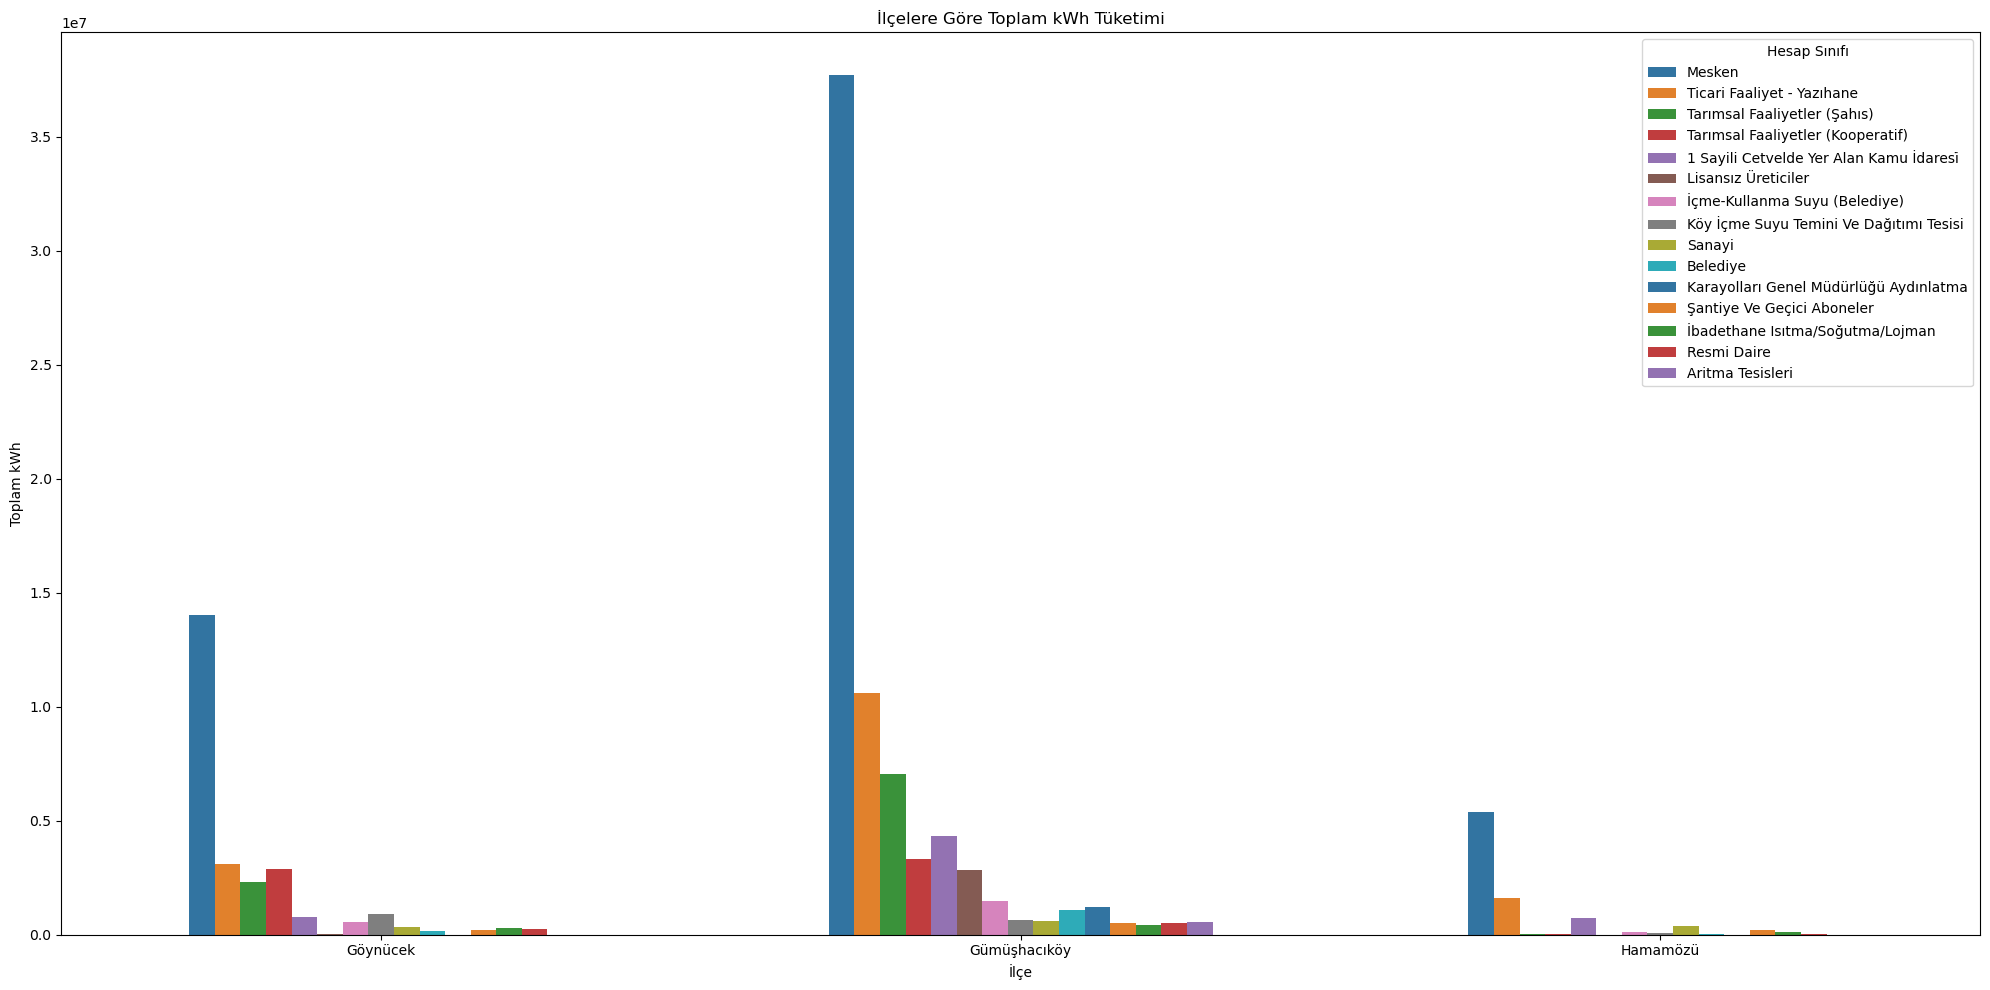

In [9]:
df_tahakkuk['Hesap Sınıfı'] = df_tahakkuk['Hesap Sınıfı'].str.title()

hesap_sira = (df_tahakkuk.groupby('Hesap Sınıfı')['kwh'].sum().sort_values(ascending=False))

top10_hesap = hesap_sira.head(15).index
palette = sns.color_palette("tab10", n_colors=len(top10_hesap))#değiş

ilce_hesap_toplam = (df_tahakkuk.groupby(['Ilce_Adi', 'Hesap Sınıfı'])['kwh'].sum().reset_index())

plt.figure(figsize=(20,10))
sns.barplot(data=ilce_hesap_toplam[ilce_hesap_toplam['Hesap Sınıfı'].isin(top10_hesap)],x='Ilce_Adi', y='kwh',hue='Hesap Sınıfı',hue_order=top10_hesap, width =0.6,dodge=True ,palette=palette)
#plt.yscale('log') #kapatılabilir.
plt.title('İlçelere Göre Toplam kWh Tüketimi')
plt.xlabel('İlçe')
plt.ylabel('Toplam kWh')
plt.tight_layout()
plt.savefig('../outputs/figures_nb3/ilce&sınıf__toplam_tuketim.png', dpi=300)
plt.show()

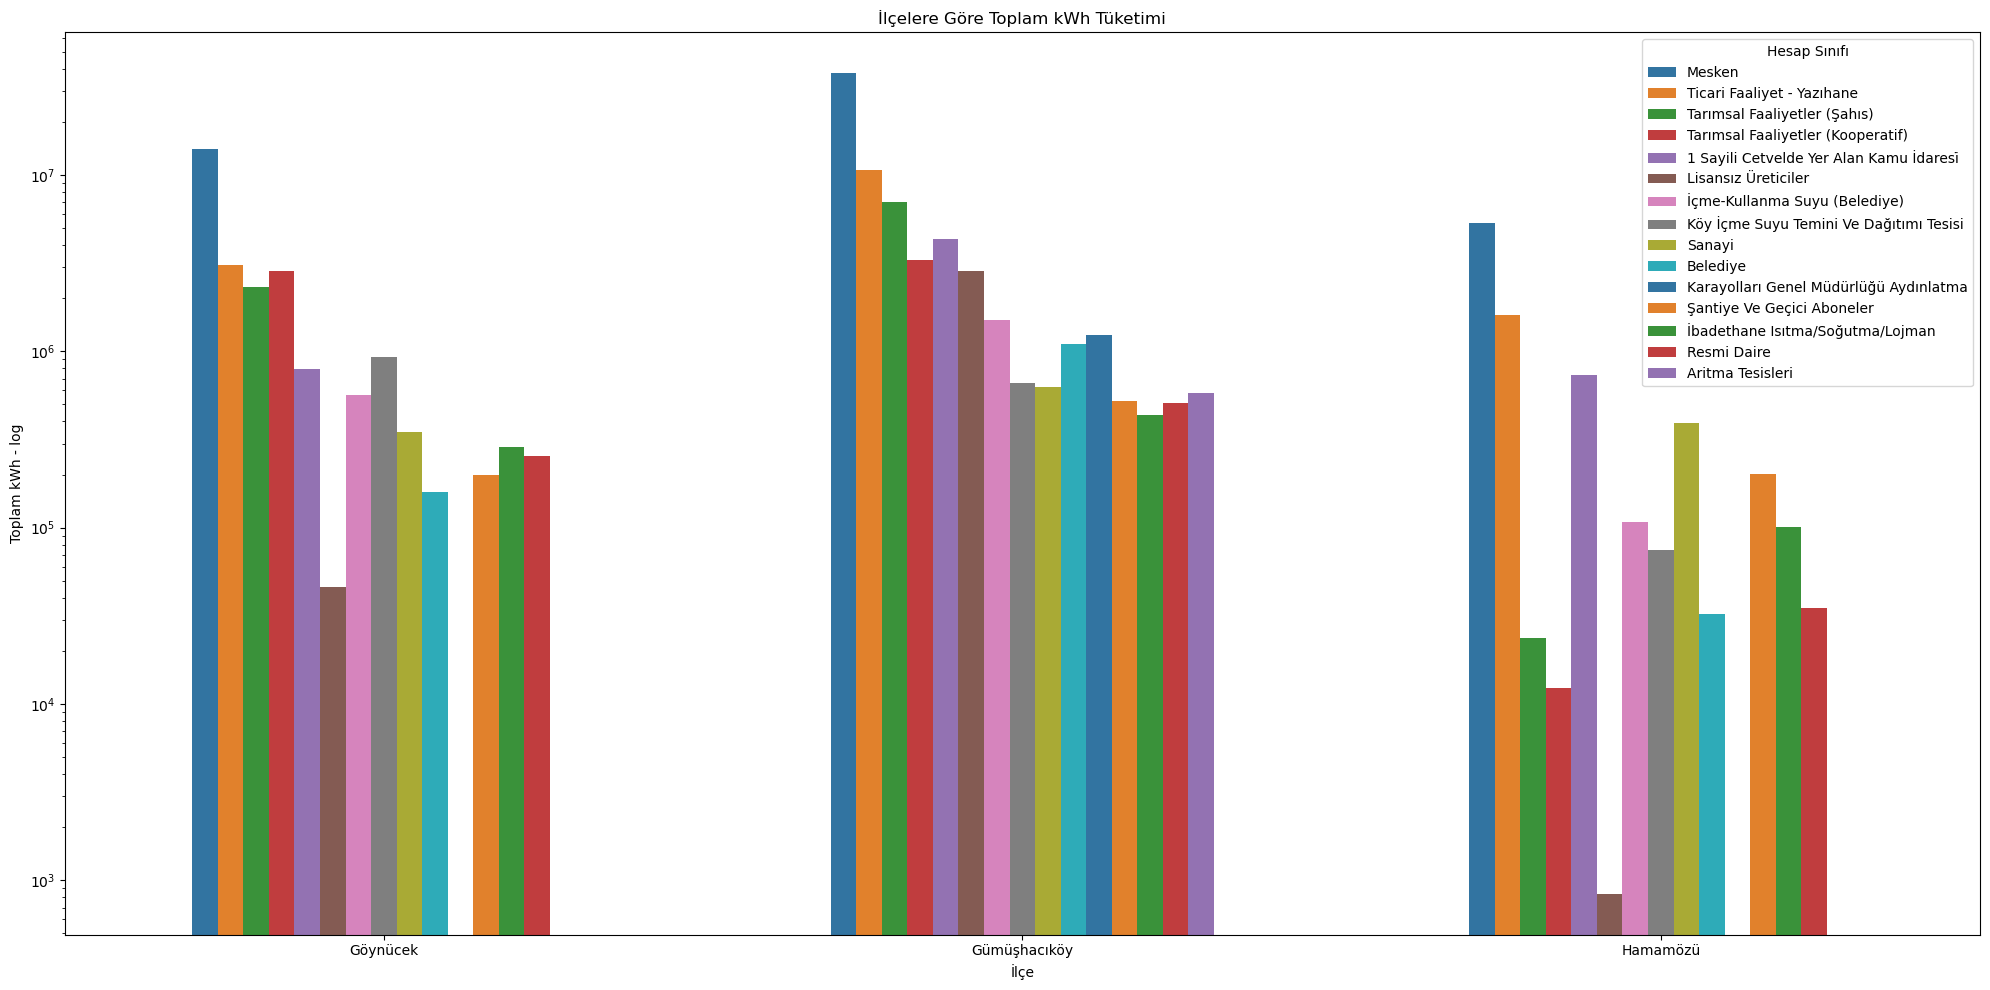

In [10]:
plt.figure(figsize=(20,10))
sns.barplot(data=ilce_hesap_toplam[ilce_hesap_toplam['Hesap Sınıfı'].isin(top10_hesap)],x='Ilce_Adi', y='kwh',hue='Hesap Sınıfı',hue_order=top10_hesap, width =0.6,dodge=True ,palette=palette)
plt.yscale('log') #kapatılabilir.
plt.title('İlçelere Göre Toplam kWh Tüketimi')
plt.xlabel('İlçe')
plt.ylabel('Toplam kWh - log')
plt.tight_layout()
plt.savefig('../outputs/figures_nb3/ilce&sınıf__toplam_tuketim_log.png', dpi=300)
plt.show()

---

Görüldüğü üzere mesken, ticari ve tarımsal faaliyetler sınıflarının toplem tüketimleri çok yüksek çıkmıştır. Ancak toplam tüketim değerleri, ilçe bazında nüfus ve toplam abone sayısından doğrudan etkilenebilmektedir. 

Bu nedenle, bu etkiyi arındırmak ve ilçeler arasındaki tüketim farklılıklarını daha sağlıklı yorumlayabilmek; abonelerin gerçek tüketim karakterini ortaya koyabilmek amacıyla ortalama tüketim değerlerinin incelenmesi gerekmektedir.

Bu analizde amaç, belirli bir ilçedeki ortalama bir sanayi, ticarethane veya benzeri sınıfın, diğer ilçelerdeki benzer hesap sınıflarıyla karşılaştırıldığında aynı yoğunlukta enerji tüketip tüketmediğini değerlendirmektir.

Bu doğrultuda, her ilçe bazında hesap sınıflarının ortalama tüketim değerleri hesaplanmıştır. Elde edilen sonuçlar, hangi ilçede hangi hesap sınıflarının birim müşteri başına daha yoğun enerji tükettiğini ortaya koyarak, tüketim davranışlarının ilçe bazında karşılaştırılmasına olanak sağlamaktadır.

---

d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
d:\anaconda\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


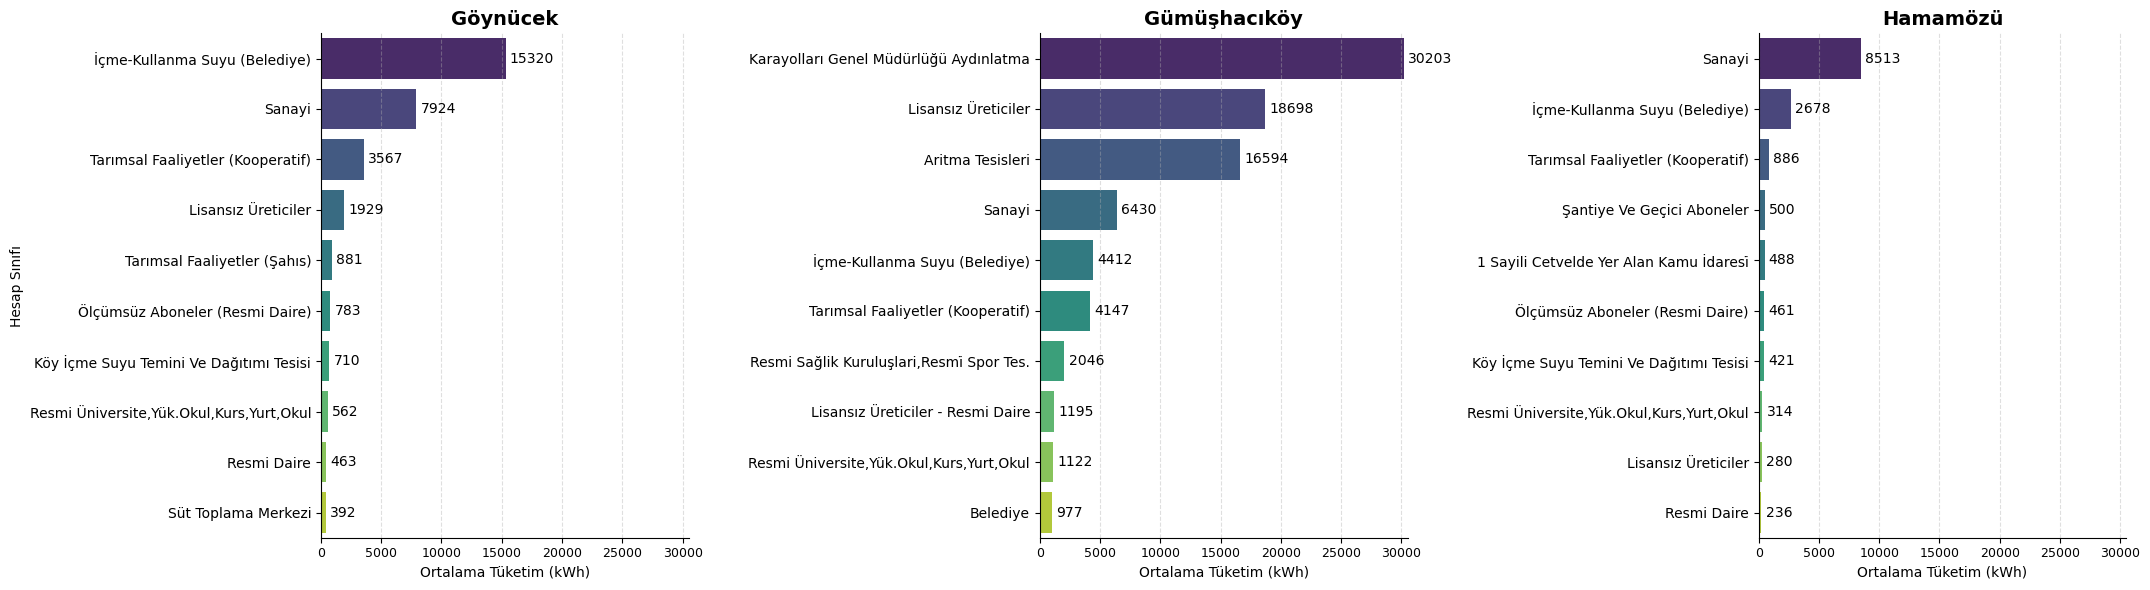

In [11]:
# İlçe ve Hesap Sınıfı bazında ortalama tüketim
ilce_bazli_ortalama = df_tahakkuk.groupby(['Ilce_Adi', 'Hesap Sınıfı'])['kwh'].mean().reset_index()

top_gruplar = []
for ilce in ilce_bazli_ortalama['Ilce_Adi'].unique():
    temp = ilce_bazli_ortalama[ilce_bazli_ortalama['Ilce_Adi'] == ilce].nlargest(10, 'kwh')
    top_gruplar.append(temp)

final_data = pd.concat(top_gruplar)
final_data['Hesap Sınıfı'] = final_data['Hesap Sınıfı'].str.title()

g = sns.FacetGrid(final_data, col="Ilce_Adi", sharey=False, sharex=False, height=6, aspect=1.2, hue="Ilce_Adi")
g.map_dataframe(sns.barplot, x="kwh", y="Hesap Sınıfı", palette="viridis")

g.set_titles("{col_name}", size=14, fontweight='bold')
g.set_axis_labels("Ortalama Tüketim (kWh)", "Hesap Sınıfı")

for ax in g.axes.flat:
    ax.grid(axis='x', linestyle='--', alpha=0.4)
    ax.tick_params(axis='y', labelsize=10)
    ax.tick_params(axis='x', labelsize=9)
    ax.set_xlim(0,30500)
    for container in ax.containers:
        ax.bar_label(container, padding=3, fmt='%.0f')
    
plt.tight_layout()
plt.savefig('../outputs/figures_nb3/ilce&sınıf_ortalama_tuketim.png', dpi=300)
plt.show()

---

Yukarıdaki grafik incelendiğinde, Gümüşhacıköy ve Göynücek ilçelerinde sanayi ve ticari kullanım sınıflarının yanı sıra kamusal hizmetler ile su, karayolları aydınlatması gibi temel altyapı sınıflarının ortalama tüketim değerlerinin oldukça yüksek olduğu görülmektedir. Bu durum, söz konusu ilçelerde enerji yoğun faaliyetlerin daha yaygın olduğunu göstermektedir.

Hamamözü ilçesinde ise ortalama tüketim bazında ilk 10 içerisinde yer alan hesap sınıflarının dahi, diğer iki ilçedeki yüksek tüketimli sınıflara kıyasla belirgin şekilde daha düşük seviyelerde kaldığı dikkat çekmektedir. Bu bulgu, Hamamözü’nün yalnızca nüfus açısından değil, aynı zamanda enerji yoğun sanayi ve ticari faaliyetler açısından da daha sınırlı bir yapıya sahip olduğuna işaret etmektedir.

Birim abone başına düşen tüketimin en yüksek olduğu sanayi ve tarımsal sulama gibi hesap sınıfları, şirket açısından stratejik öneme sahip yüksek değerli müşteri segmentleri olarak değerlendirilebilir. Bu gruplar, abone sayısı bakımından görece küçük olsalar da, hem şebeke üzerindeki yük hem de ciroya olan katkıları açısından kritik bir konumdadır.

Özellikle ortalama tüketimi 10.000 kWh seviyesinin üzerinde olan hesap sınıfları, olası enerji kesintilerinden en fazla etkilenecek ve ekonomik etkisi en yüksek olacak aboneler olarak öne çıkmaktadır. Bu kapsamda, arıtma tesisleri, içme-kullanma suyu tesisleri ve karayolları aydınlatması gibi sınıfların bakım, yatırım ve kesinti planlamalarında önceliklendirilmesi gerektiği değerlendirilmektedir.

---

## 3. Müşteri Segmentasyonu

Bu bölümde, müşteriler elektrik tüketim miktarlarına göre segmentlere ayrılarak analiz edilmiştir. Müşteri segmentasyonu, farklı tüketim profillerine sahip aboneler için özelleştirilmiş aksiyon planlarının geliştirilmesine olanak sağlamaktadır.

Tüketim miktarına dayalı segmentasyon sayesinde, tahsilat stratejileri, fiyatlandırma politikaları, risk değerlendirmeleri ve enerji verimliliği çalışmalarının müşteri profiline göre şekillendirilmesi mümkün hale gelmektedir.

---

Bu analiz kapsamında müşteriler, aylık elektrik tüketim miktarlarına göre üç ana segmente ayrılmıştır:

- **Düşük Tüketim (0–100 kWh):** Genellikle düşük kullanım yoğunluğuna sahip mesken aboneleri
- **Orta Tüketim (101–500 kWh):** Standart mesken ve küçük ölçekli ticari aboneler
- **Yüksek Tüketim (500+ kWh):** Ticari işletmeler, sanayi tesisleri ve enerji yoğun aboneler


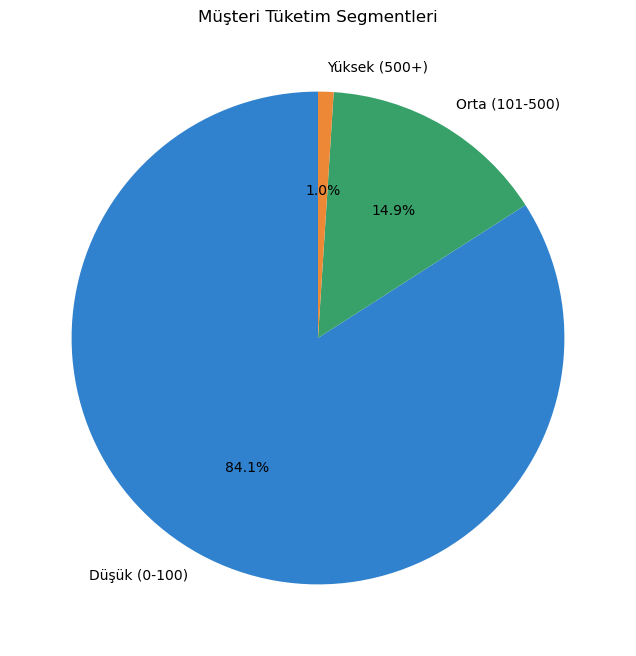

In [14]:
def segment_customer(kwh):
    if kwh <= 100:
        return 'Düşük (0-100)'
    elif kwh <= 500:
        return 'Orta (101-500)'
    else:
        return 'Yüksek (500+)'

df_tahakkuk['Segment'] = df_tahakkuk['kwh'].apply(segment_customer)

segment_counts = df_tahakkuk['Segment'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', colors=colors1, startangle=90)
plt.title('Müşteri Tüketim Segmentleri')
plt.savefig('../outputs/figures_nb3/musteri_tuketim_segment_dagilimi.png', dpi=300)
plt.show()

Segmentasyon sonuçları incelendiğinde, müşterilerin büyük bir bölümünün düşük ve orta tüketim segmentlerinde yoğunlaştığı görülmektedir. Bu durum, abone yapısının ağırlıklı olarak mesken ve düşük ölçekli ticari kullanımlardan oluştuğunu göstermektedir.

Yüksek tüketim segmentinde yer alan müşteri sayısı görece sınırlı olmakla birlikte, bu grubun toplam tüketim ve gelir üzerindeki etkisi oldukça yüksektir. Bu nedenle, yüksek tüketimli aboneler şirket açısından stratejik öneme sahip müşteri segmentleri olarak (VIP) değerlendirilmelidir.

Elde edilen segmentasyon, düşük tüketimli müşteriler için otomatik ve düşük maliyetli süreçlerin, yüksek tüketimli müşteriler için ise daha yakından takip edilen, risk ve hizmet sürekliliği odaklı aksiyonların planlanabileceğini göstermektedir.


---

Ayrıca, müşteri segmentlerinin ilçe bazında nasıl dağıldığı incelenmesi de gerekir. Amaç, yüksek ve düşük tüketim segmentlerinin belirli ilçelerde yoğunlaşıp yoğunlaşmadığını ve ilçelerin müşteri profillerinin birbirinden nasıl ayrıştığını ortaya koymaktır.

---

C:\Users\Enes\AppData\Local\Temp\ipykernel_21208\1516375859.py:6: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(data=segment_ilce[segment_ilce['Ilce_Adi'].isin(top_ilceler)], x='Ilce_Adi', y='musteri_sayisi', hue='Segment', palette=colors1)


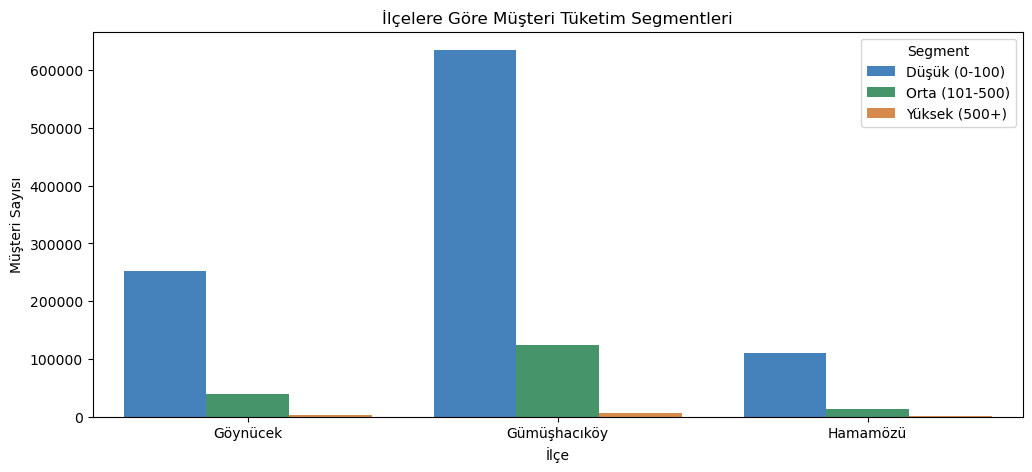

In [15]:
segment_ilce = (df_tahakkuk.groupby(['Ilce_Adi', 'Segment']).size().reset_index(name='musteri_sayisi'))

top_ilceler = (df_tahakkuk.groupby('Ilce_Adi')['kwh'].mean().sort_values(ascending=False).index)

plt.figure(figsize=(12,5))
sns.barplot(data=segment_ilce[segment_ilce['Ilce_Adi'].isin(top_ilceler)], x='Ilce_Adi', y='musteri_sayisi', hue='Segment', palette=colors1)

#plt.yscale('log')
plt.title('İlçelere Göre Müşteri Tüketim Segmentleri')
plt.xlabel('İlçe')
plt.ylabel('Müşteri Sayısı')
plt.savefig('../outputs/figures_nb3/ilce_bazli_musteri_tuketim_segment_dagilimi.png', dpi=300)
plt.show()

C:\Users\Enes\AppData\Local\Temp\ipykernel_21512\612042767.py:2: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.barplot(data=segment_ilce[segment_ilce['Ilce_Adi'].isin(top_ilceler)], x='Ilce_Adi', y='musteri_sayisi', hue='Segment', palette=colors1)


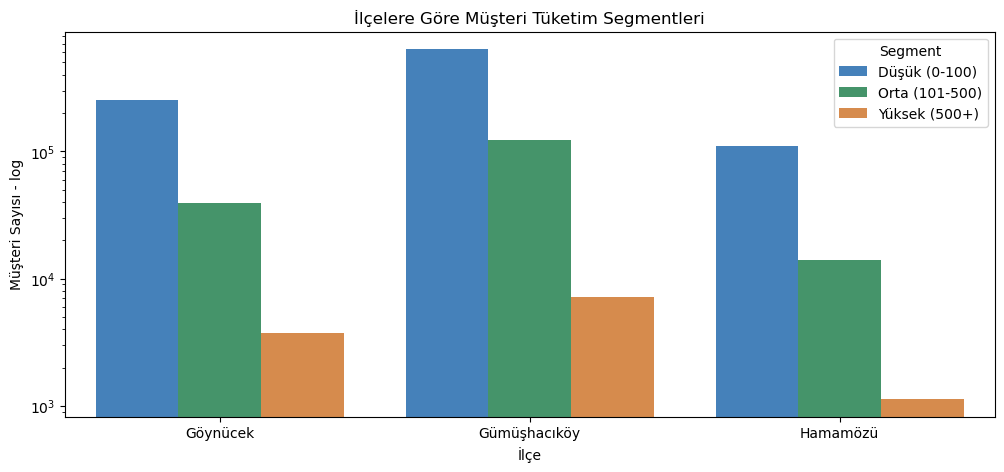

In [12]:
plt.figure(figsize=(12,5))
sns.barplot(data=segment_ilce[segment_ilce['Ilce_Adi'].isin(top_ilceler)], x='Ilce_Adi', y='musteri_sayisi', hue='Segment', palette=colors1)
plt.yscale('log')
plt.title('İlçelere Göre Müşteri Tüketim Segmentleri')
plt.xlabel('İlçe')
plt.ylabel('Müşteri Sayısı - log')
plt.savefig('outputs/figures_nb3/ilce_bazli_musteri_tuketim_segment_dagilimi_log.png', dpi=300)
plt.show()

---

Grafikler incelendiğinde, tüm ilçelerde müşteri portföyünün ağırlıklı olarak düşük ve orta tüketim segmentlerinden oluştuğu görülmektedir. Bu durum, abone yapısının genel olarak mesken ve küçük ölçekli ticari kullanımlar tarafından domine edildiğini göstermektedir.

Gümüşhacıköy ilçesi, hem düşük hem de orta tüketim segmentlerinde en yüksek müşteri sayısına sahip ilçe olarak öne çıkmaktadır. Ayrıca yüksek tüketim segmentindeki müşteri sayısının da diğer ilçelere kıyasla daha fazla olması, bu ilçede sanayi ve enerji yoğun ticari faaliyetlerin daha yaygın olduğunu göstermektedir.

Göynücek ilçesi, Gümüşhacıköy’e kıyasla daha sınırlı bir müşteri hacmine sahip olmakla birlikte, yüksek tüketim segmentinin varlığı açısından Hamamözü’nden ayrışmaktadır. Bu durum, Göynücek’in ekonomik yapı bakımından geçiş niteliğinde bir profile sahip olduğunu düşündürmektedir.

Hamamözü ilçesinde ise yüksek tüketim segmentindeki müşteri sayısının oldukça düşük olduğu dikkat çekmektedir. Bu bulgu, ilçede enerji yoğun sanayi veya büyük ölçekli ticari işletmelerin sınırlı olduğunu ve toplam tüketim seviyelerinin neden daha düşük kaldığını tekrar açıklamaktadır.

Sonuç olarak, ilçeler arasındaki toplam tüketim ve tahsilat farklarının yalnızca müşteri sayısından değil, müşteri segmenti dağılımındaki farklılıklardan da kaynaklandığı görülmektedir. Özellikle yüksek tüketim segmentinin yoğunlaştığı ilçeler, altyapı planlaması, hizmet sürekliliği ve tahsilat stratejileri açısından öncelikli değerlendirilmelidir.

---

In [16]:
segment_ozet = (segment_counts.rename('Müşteri Sayısı').reset_index().rename(columns={'index': 'Tüketim Segmenti'}))

segment_ozet

,Segment,Müşteri Sayısı
0,Düşük (0-100),996741
1,Orta (101-500),176765
2,Yüksek (500+),12041


## 4.BONUS: Tahsilat Performans Analizi

Bu aşamada, müşterilerin ödeme alışkanlıkları analiz edilerek tahsilat performansını etkileyen faktörler incelenmiştir.

Ödeme durumu, müşterinin faturasını:
- Son ödeme tarihinden **önce** veya **son ödeme tarihinde** ödemesi durumunda **Zamanında**,
- Bu tarihler dışında kalan tüm durumlarda **Geç** ödeme olarak sınıflandırılmıştır.

In [17]:
zamaninda_sutunlar = ['Son Ödeme Tarihinden Önceki Tahsilat','Son Ödeme Tarihindeki Tahsilat']

df_tahsilat_1['odeme_durumu'] = ( df_tahsilat_1[zamaninda_sutunlar].notna().any(axis=1).map({True: 'Zamanında', False: 'Geç'}))


df_tahsilat_1['odeme_durumu'].value_counts()

odeme_durumu
Zamanında    789588
Geç          128044
Name: count, dtype: int64

In [18]:
ilce_gec_oran = (df_tahsilat_1.groupby(['İlçe', 'odeme_durumu']).size().unstack())

ilce_gec_oran = ilce_gec_oran.div(ilce_gec_oran.sum(axis=1), axis=0)

ilce_gec_oran

odeme_durumu,Geç,Zamanında
İlçe,,
GÖYNÜCEK,0.156258,0.843742
GÜMÜŞHACIKÖY,0.127667,0.872333
HAMAMÖZÜ,0.148538,0.851462
TAŞOVA,0.142347,0.857653


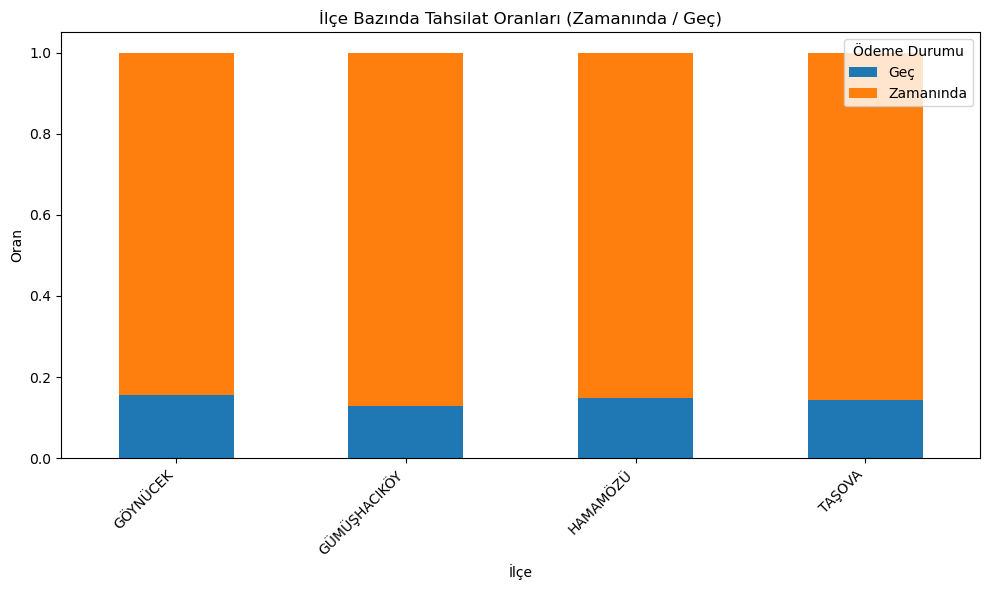

In [19]:
plt.figure(figsize=(10, 6))

ilce_gec_oran.plot(kind='bar',stacked=True, ax=plt.gca())

plt.title('İlçe Bazında Tahsilat Oranları (Zamanında / Geç)')
plt.xlabel('İlçe')
plt.ylabel('Oran')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Ödeme Durumu')

plt.tight_layout()
plt.savefig('../outputs/figures_nb3/zamanında_gec_tahsilat_oranları.png', dpi=300)
plt.show()

İlçe bazında ödeme davranışları incelendiğinde,
tüm ilçelerde zamanında ödeme oranlarının %84’ün üzerinde olduğu görülmektedir.
Bu durum, genel tahsilat disiplininin yüksek olduğunu göstermektedir.

Bununla birlikte ilçeler arasında geç ödeme oranları açısından
belirgin farklılıklar bulunmaktadır.
Göynücek ilçesi %15,6 ile en yüksek geç ödeme oranına sahipken,
Gümüşhacıköy ilçesi %12,8 ile en düşük geç ödeme oranını göstermektedir.
Hamamözü (%14,9) ve Taşova (%14,2) ilçeleri ise orta seviyede konumlanmaktadır

### Tahsilat Riski Değerlendirmesi

Geç ödeme oranları tek başına değerlendirildiğinde, tahsilat riskinin gerçek etkisini tam olarak yansıtmayabilir.
Bu nedenle analiz, ilçe bazındaki kayıtlı abone sayıları ile birlikte ele alınmıştır.

Bu yaklaşım sayesinde:
- Geç ödeme oranı düşük olsa bile abone sayısı yüksek olan ilçelerde
  mutlak tahsilat riski,
- Abone sayısı düşük olmasına rağmen geç ödeme oranı yüksek olan ilçelerde
  davranışsal tahsilat riski tespit edilebilmektedir.

In [20]:
gec_oran = ilce_gec_oran['Geç'].reset_index()
gec_oran.columns = ['İlçe', 'Gec_Odeme_Orani']

abone_sayisi = (df_tahakkuk.groupby('Ilce_Adi').agg(Abone_Sayisi=('sozlesme_hesap_no', 'nunique')).reset_index())

abone_sayisi.columns = ['İlçe', 'Abone_Sayisi']

gec_oran['İlçe'] = gec_oran['İlçe'].astype(str).str.strip().str.upper()
abone_sayisi['İlçe'] = abone_sayisi['İlçe'].astype(str).str.strip().str.upper()

risk_df = gec_oran.merge(abone_sayisi,on='İlçe', how='left')

risk_df['Risk_Skoru'] = risk_df['Gec_Odeme_Orani'] * risk_df['Abone_Sayisi']

risk_df

,İlçe,Gec_Odeme_Orani,Abone_Sayisi,Risk_Skoru
0,GÖYNÜCEK,0.156258,7128.0,1113.808991
1,GÜMÜŞHACIKÖY,0.127667,18190.0,2322.254485
2,HAMAMÖZÜ,0.148538,2981.0,442.792230
3,TAŞOVA,0.142347,NaN,NaN


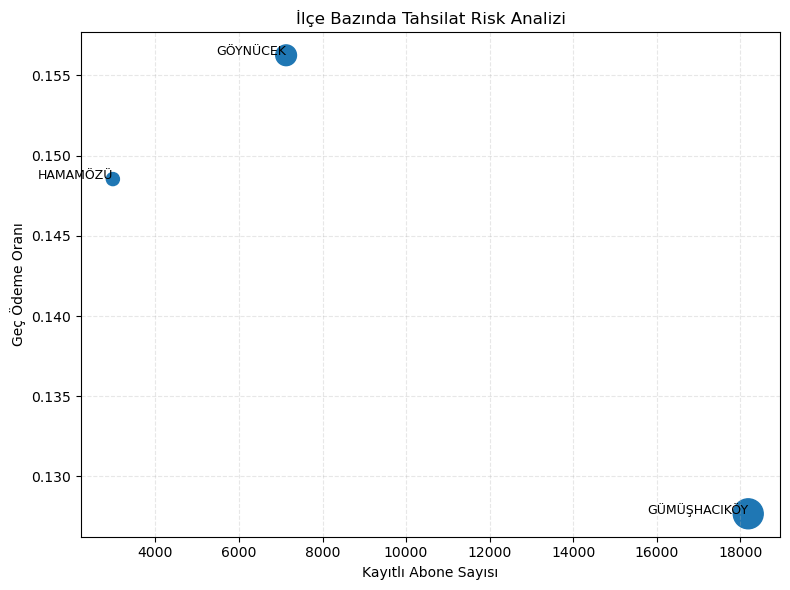

In [23]:
risk_df_plot = risk_df.dropna(subset=['Abone_Sayisi'])

plt.figure(figsize=(8,6))

plt.scatter(risk_df_plot['Abone_Sayisi'],risk_df_plot['Gec_Odeme_Orani'], s=risk_df_plot['Risk_Skoru'] / 5)

for _, row in risk_df_plot.iterrows():
    plt.text(row['Abone_Sayisi'],row['Gec_Odeme_Orani'], row['İlçe'], fontsize=9, ha='right')

plt.xlabel('Kayıtlı Abone Sayısı')
plt.ylabel('Geç Ödeme Oranı')
plt.title('İlçe Bazında Tahsilat Risk Analizi')

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures_nb3/ilce_bazli_tahsilat_risk_analizi.png', dpi=300)
plt.show()


Grafik incelendiğinde **Gümüşhacıköy** ilçesi, geç ödeme oranı görece düşük olmasına rağmen yüksek kayıtlı abone sayısı nedeniyle tahsilat riski açısından öne çıkmaktadır. Bu durum, küçük oranların yüksek hacimle birleştiğinde önemli bir risk oluşturabileceğini göstermektedir.

**Göynücek** ilçesi ise daha düşük abone sayısına sahip olmasına rağmen yüksek geç ödeme oranı ile tahsilat riski açısından dikkat çekmektedir. Bu ilçe için ödeme alışkanlıklarının iyileştirilmesine yönelik hedefli müdahaleler gerekmektedir.

**Hamamözü** ilçesi, hem abone sayısının düşük olması hem de geç ödeme oranının orta seviyede kalması nedeniyle görece düşük risk profiline sahiptir.

Bu grafik, tahsilat riskinin yalnızca geç ödeme oranları ile değil, abone hacmi ile birlikte değerlendirilmesi gerektiğini açık biçimde ortaya koymaktadır.

---

## 5. Bulgular ve Stratejik İş Önerileri

Bu bölümde, tüketim, tahsilat ve müşteri segmentasyonu analizlerinden
elde edilen bulgular doğrultusunda,
gelir sürekliliğini artırmaya ve operasyonel verimliliği iyileştirmeye yönelik
stratejik iş önerileri sunulmaktadır.

### Bulgular
1. **Bölgesel Yoğunlaşma:**
   İlçe bazlı analizler, Gümüşhacıköy ilçesinin hem kayıtlı abone sayısı
   hem de toplam elektrik tüketimi açısından bölgenin en büyük pazarını
   oluşturduğunu göstermektedir.
   Hamamözü ilçesi ise daha sınırlı bir müşteri profiline ve düşük tüketim
   seviyelerine sahiptir.

2. **Tüketim Segmentasyonu:**
   Müşteri portföyünün %80’den fazlası düşük tüketim segmentinde yer almakta olup,
   bu durum abone yapısının ağırlıklı olarak mesken kullanımlarından oluştuğunu
   ortaya koymaktadır.
   Buna karşın, toplam müşteri sayısı içerisindeki payı sınırlı olan
   yüksek tüketimli aboneler,
   toplam tüketim ve gelir üzerinde orantısız derecede yüksek etkiye sahiptir.

3. **Mevsimsellik Etkisi:**
   Aylık tüketim analizleri, özellikle Temmuz ve Ağustos aylarında
   tarımsal sulama faaliyetleri ve klima kullanımına bağlı olarak
   belirgin tüketim artışları yaşandığını göstermektedir.
   Bu dönemler, hem şebeke yükü hem de tahsilat süreçleri açısından
   kritik öneme sahiptir.

4. **Tahsilat ve Risk Dağılımı:**
   İlçe bazında yapılan tahsilat risk analizleri,
   geç ödeme oranlarının ilçelere göre farklılık gösterdiğini ortaya koymaktadır.
   Gümüşhacıköy ilçesi, görece düşük geç ödeme oranına rağmen
   yüksek abone sayısı nedeniyle mutlak tahsilat riski taşırken,
   Göynücek ilçesi yüksek geç ödeme oranı ile
   davranışsal tahsilat riski açısından öne çıkmaktadır.

---


### Stratejik İş Önerileri

1. **Tahsilat ve Ödeme Yönetimi Stratejileri:**
   Tarımsal sulama aboneleri için hasat dönemine (Eylül–Ekim) uyumlu
   esnek ödeme planları geliştirilmelidir.
   Geç ödeme oranı yüksek olan ilçe ve müşteri segmentleri için,
   fatura kesimini takiben otomatik SMS ve dijital hatırlatma sistemleri
   devreye alınarak tahsilat gecikmeleri azaltılabilir.

2. **Yüksek Tüketimli Müşterilere Yönelik Özel Yaklaşımlar:**
   Toplam müşteri sayısı içerisindeki payı sınırlı olmasına rağmen,
   toplam tüketim ve gelir üzerinde yüksek etkiye sahip olan
   “Yüksek Tüketim” segmentine yönelik özel tarifeler,
   enerji verimliliği danışmanlığı ve kişiselleştirilmiş müşteri yönetimi
   uygulamaları hayata geçirilmelidir.
   Bu yaklaşım, müşteri bağlılığını artırarak gelir istikrarını destekleyecektir.

3. **Bölgesel ve Mevsimsel Altyapı Planlaması:**
   Yaz aylarında oluşan tepe tüketimlerin güvenli şekilde karşılanabilmesi için,
   Gümüşhacıköy ilçesindeki trafolar ve kritik şebeke bileşenleri
   yaz dönemi öncesinde bakım ve kapasite kontrolleri açısından
   önceliklendirilmelidir.
   Mevsimsel yük artışlarının öngörülmesi,
   kesinti risklerinin azaltılmasına katkı sağlayacaktır.

4. **Veri Tabanlı Karar Destek Mekanizmaları:**
   İlçe ve müşteri segmenti bazında oluşturulan risk göstergeleri,
   düzenli olarak güncellenmeli ve
   tahsilat, yatırım ve müşteri yönetimi kararlarında
   aktif olarak kullanılmalıdır.


---

Bu çalışma, elektrik tüketimi ve tahsilat süreçlerinin bölgesel, mevsimsel ve müşteri profiline bağlı olarak farklı dinamikler sergilediğini ortaya koymaktadır.

Veriye dayalı stratejik yaklaşımlar sayesinde, tahsilat performansının iyileştirilmesi, yüksek değerli müşteri segmentlerinin korunması ve altyapı yatırımlarının daha etkin planlanması mümkün hale gelebilir.

---

MEHMET ENES TEMEL

mehmetenestemel@gmail.com